<a href="https://colab.research.google.com/github/yinon2592/DL_Project_046211/blob/main/section_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# using https://www.kaggle.com/code/baekseungyun/gpt-2-with-huggingface-pytorch

In [ ]:
from google.colab import drive
# drive.mount('/content/drive/my-drive/project_calculations')
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# our code begin
file_path = '/content/drive/My Drive/project_calculations/section_a_model_description.txt'

text_content = """
  train size : 400,000
  validation size : 100,000
  prompt : text = ["<startoftext> " + str(sequence['text']) + "\nwas the previous text positive or negative " + "<endoftext>" for sequence in sequences]
  total_epochs = 3
"""

with open(file_path, 'w') as file:
    file.write(text_content)
# our code end

In [ ]:
! pip install transformers
from transformers import set_seed, GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification
import os
import pandas as pd
from torch.utils.data import Dataset
import re
import torch

# model preparation

set_seed(731)

model_config = GPT2Config.from_pretrained('gpt2', num_labels=2) # Binary Classification
model = GPT2ForSequenceClassification.from_pretrained('gpt2', config=model_config)

# our code begin
load_model_parameters = False
model_path = '/content/drive/My Drive/project_calculations/model.pth'
if os.path.exists(model_path) and load_model_parameters:
  print("loading last model parameters..")
  model.load_state_dict(torch.load(model_path))
# our code end

# tokenizer preparation
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left" # Very Important
tokenizer.pad_token = tokenizer.eos_token
tokenizer.bos_token = "<startoftext>"
tokenizer.eos_token = "<endoftext>"

model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# our code begin
# Step 1: Dataset Preparation
# load section_a data (data already cleaned)
section_a_data_path = '/content/drive/My Drive/project_dataset/section_a_data.csv'
df = pd.read_csv(section_a_data_path)
df = df.head(500_000)
print("dataset size is ", df.shape[0])
print(df.label.value_counts())
print(df.sample(5), "\n")

train_size = int(len(df) * 0.8)  # 80% for training
print("train_size is ", train_size)
val_size = len(df) - train_size  # remaining for validation
print("val_size is ", val_size)

train_dataset = df[:train_size]  # First train_size rows for training
val_dataset = df[train_size:train_size+val_size]  # Remaining val_size rows for validation
# our code end

# data arrangement
class TweetDataset(Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.data = dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        record = self.data.iloc[index]
        text = record['text']
        return {'text': text, 'label': record['label']}

train_dataset = TweetDataset(dataset=train_dataset)
val_dataset = TweetDataset(dataset=val_dataset)

dataset size is  500000
1    250022
0    249978
Name: label, dtype: int64
        label                                               text
10760       0        so little time until i move out of my house
227547      1  i m sorry tell yourself that the rain is what ...
291335      1  jesus the heavy rotation tour is almost starti...
348028      0  is no longer hungover but really doesn t want ...
48892       1                                  morgen housequake 

train_size is  400000
val_size is  100000


In [ ]:
class Gpt2ClassificationCollator(object):
    def __init__(self, tokenizer, max_seq_len=None):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

        return

    def __call__(self, sequences):
        # our code begin
        texts = ["<startoftext> " + str(sequence['text']) + "\nwas the previous text positive or negative " + "<endoftext>" for sequence in sequences]
        labels = [int(sequence['label']) for sequence in sequences]
        # our code end
        inputs = self.tokenizer(text=texts,
                                return_tensors='pt',
                                padding=True,
                                truncation=True,
                                max_length=self.max_seq_len)
        inputs.update({'labels': torch.tensor(labels)})

        return inputs

gpt2classificationcollator_train = Gpt2ClassificationCollator(tokenizer=tokenizer,
                                                        max_seq_len=512)
gpt2classificationcollator_val = Gpt2ClassificationCollator(tokenizer=tokenizer,
                                                        max_seq_len=512)

In [ ]:
from torch.utils.data import DataLoader, random_split
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True,
                              collate_fn=gpt2classificationcollator_train)
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=32,
                            shuffle=False,
                            collate_fn=gpt2classificationcollator_val)

In [ ]:
from transformers import AdamW, get_cosine_schedule_with_warmup

## our code begin

# optional features extracting (we got inferior results compare to fine tuning)

# last_layers_names =[
#   'transformer.h.11.mlp.c_fc.weight',
#   'transformer.h.11.mlp.c_fc.bias',
#   'transformer.h.11.mlp.c_proj.weight',
#   'transformer.h.11.mlp.c_proj.bias',
#   'transformer.ln_f.weight',
#   'transformer.ln_f.bias',
#   'score.weight'
# ]

# # Set require_grad to False for all levels except the last one
# parameters = []
# for name, param in model.named_parameters():
#   # print("name = ", name, " ", "type = ", type(name), " ", "param = ", param)
#   if not name in last_layers_names:  # Exclude parameters of the last layer
#     param.requires_grad = False
#   else:
#     print("name = ", name)
#     param.requires_grad = True
#     parameters.append(param)

## our code end

total_epochs = 3

print(model)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters,
                  lr=1e-4,
                  eps=1e-8)

num_train_steps = len(train_dataloader) * total_epochs
num_warmup_steps = int(num_train_steps * 0.1)

lr_scheduler = get_cosine_schedule_with_warmup(optimizer,
                                               num_warmup_steps=num_warmup_steps,
                                               num_training_steps = num_train_steps)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import torch

def train(dataloader, optimizer, scheduler, device_):
    global model
    model.train()

    prediction_labels = []
    true_labels = []

    total_loss = []

    for batch in dataloader:
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device_) for k, v in batch.items()}


        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # prevent exploding gradient

        optimizer.step()
        scheduler.step()

        prediction_labels += logits.argmax(axis=-1).flatten().tolist()

    return true_labels, prediction_labels, total_loss

def validation(dataloader, device_):
    global model
    model.eval()

    prediction_labels = []
    true_labels = []

    total_loss = []

    for batch in dataloader:
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device_) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss.append(loss.item())

            prediction_labels += logits.argmax(axis=-1).flatten().tolist()

    return true_labels, prediction_labels, total_loss

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

all_loss = {'train_loss': [], 'val_loss': []}
all_acc = {'train_acc': [], 'val_acc': []}

best_val = 0

for epoch in range(total_epochs):

    start_time = time.time()  # Start the timer
    y, y_pred, train_loss = train(train_dataloader, optimizer, lr_scheduler, device)
    train_acc = accuracy_score(y, y_pred)

    y, y_pred, val_loss = validation(val_dataloader, device)
    val_acc = accuracy_score(y, y_pred)

    # all_loss['train_loss'] += train_loss
    # all_loss['val_loss'] += val_loss

    all_loss['train_loss'].append(train_loss)
    all_loss['val_loss'].append(val_loss)


    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)

    end_time = time.time()  # Stop the timer
    epoch_duration = end_time - start_time

    # our code begin
    if val_acc > best_val:
      best_val = val_acc
      # Save your model to Google Drive
      print(" current best val_acc is ", best_val)
      torch.save(model.state_dict(), '/content/drive/My Drive/project_calculations/section_a_model.pth')

    pd.DataFrame.from_dict(all_loss).to_csv('/content/drive/My Drive/project_calculations/section_a_all_loss.csv', index=False)
    pd.DataFrame.from_dict(all_acc).to_csv('/content/drive/My Drive/project_calculations/section_a_all_acc.csv', index=False)
    # our code end

    print(f"Epoch: {epoch}, Train Loss: {torch.tensor(train_loss).mean():.3f}, Train Acc: {train_acc:.3f}, Val Loss: {torch.tensor(val_loss).mean():.3f}, Val Acc: {val_acc:.3f}, Epoch Duration: {epoch_duration:.3f} seconds")


 current best val_acc is  0.61664
Epoch: 0, Train Loss: 0.621, Train Acc: 0.665, Val Loss: 0.674, Val Acc: 0.617, Epoch Duration: 1581.118 seconds
 current best val_acc is  0.63691
Epoch: 1, Train Loss: 0.682, Train Acc: 0.616, Val Loss: 0.669, Val Acc: 0.637, Epoch Duration: 1541.727 seconds
 current best val_acc is  0.64615
Epoch: 2, Train Loss: 0.644, Train Acc: 0.640, Val Loss: 0.625, Val Acc: 0.646, Epoch Duration: 1540.613 seconds


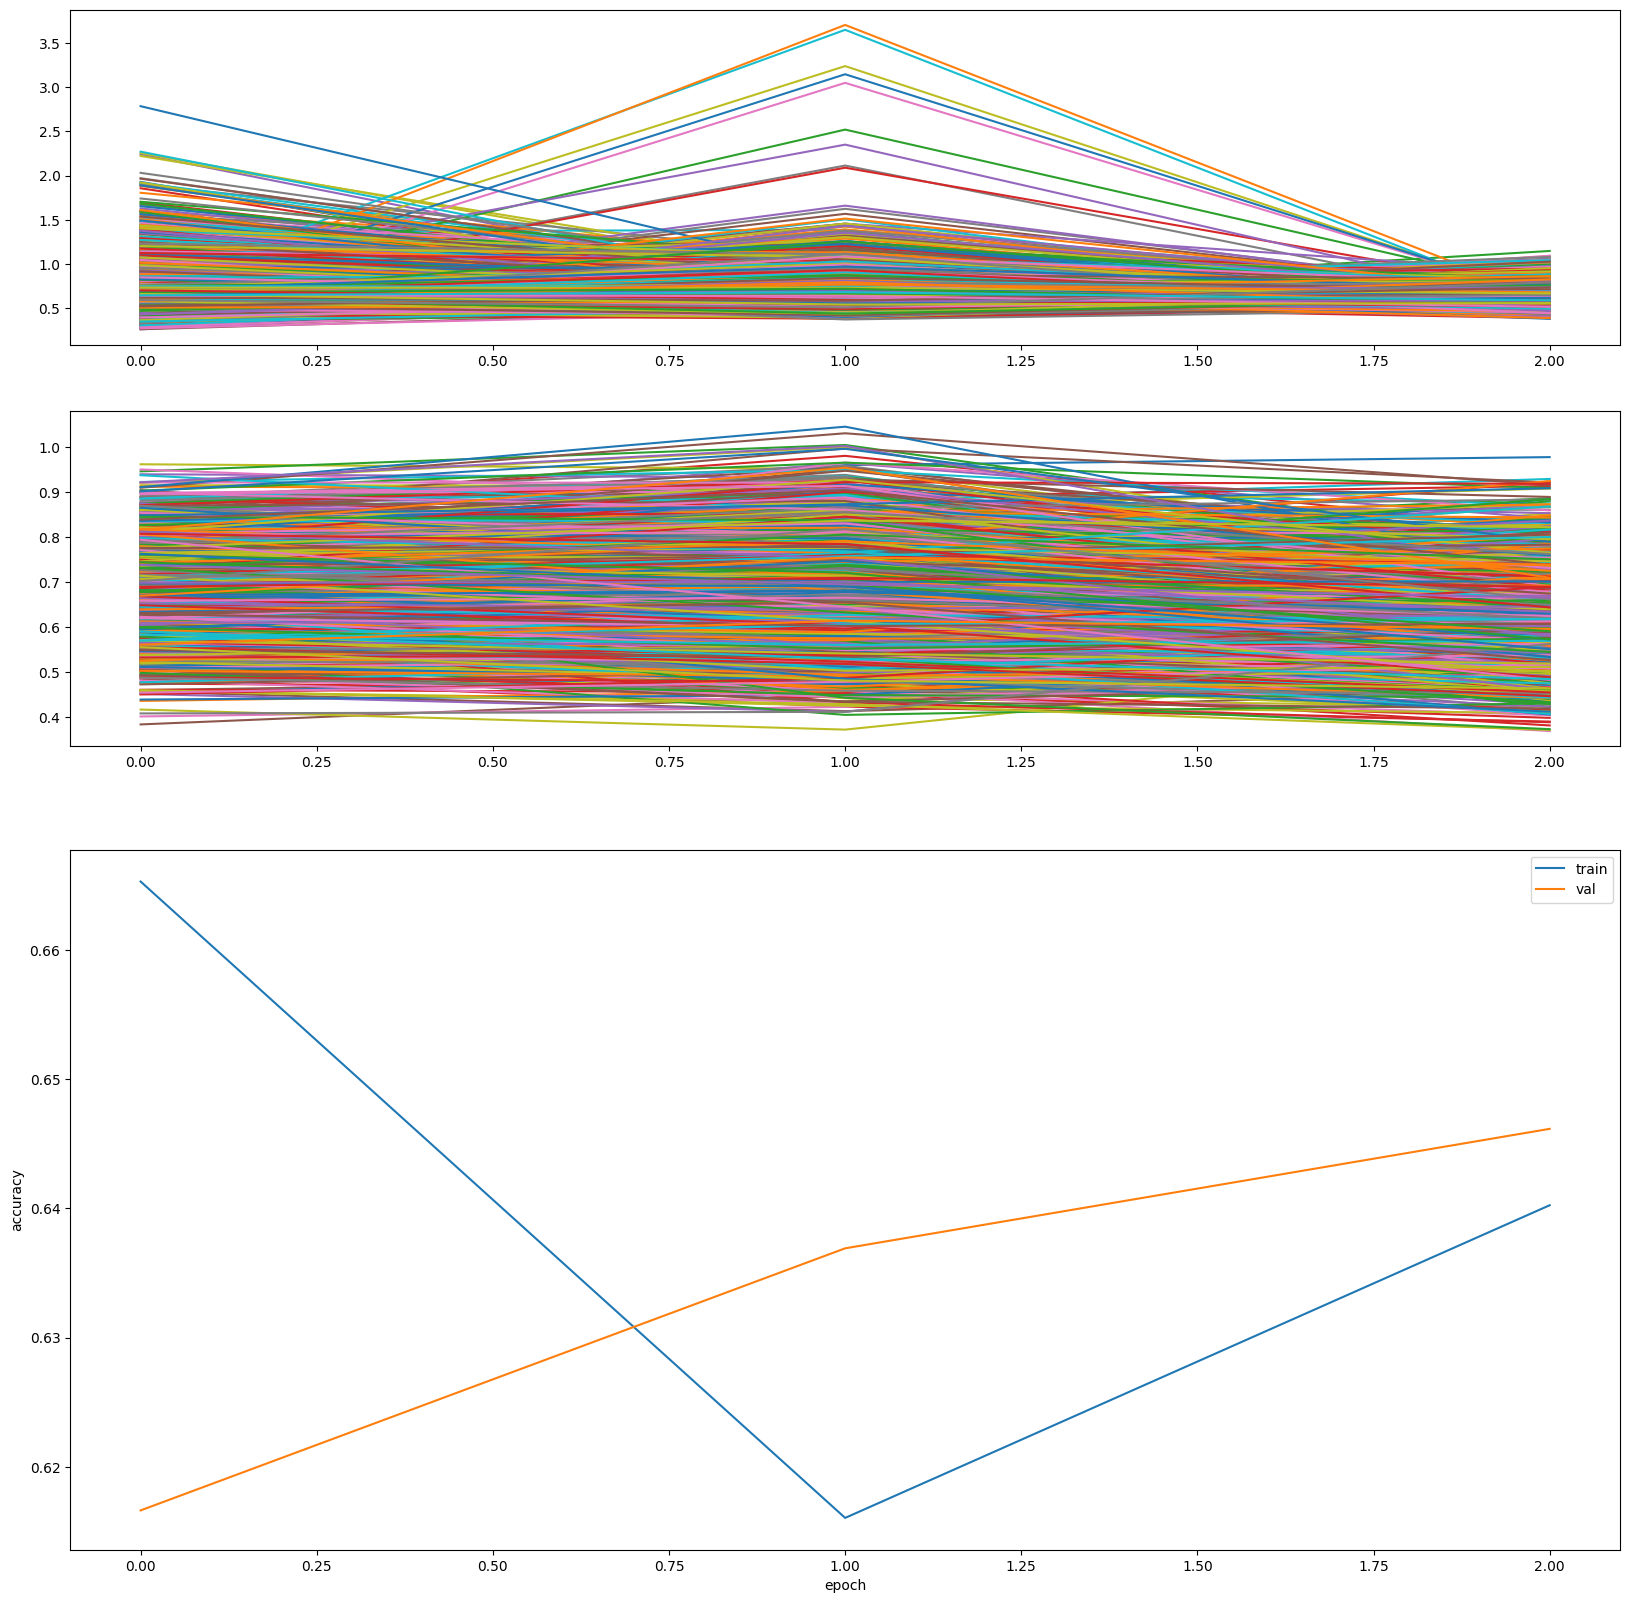

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(20,20))
a = fig.add_subplot(4, 1, 1)
b = fig.add_subplot(4, 1, 2)
c = fig.add_subplot(2, 1, 2)
a.plot(all_loss['train_loss'])
b.plot(all_loss['val_loss'])
c.plot(all_acc['train_acc'])
c.plot(all_acc['val_acc'])
c.set(xlabel='epoch', ylabel='accuracy')
c.legend(['train', 'val'])